In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Finetuning Tutorial

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fmodel_garden%2Fmodel_garden_finetuning_tutorial.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_finetuning_tutorial.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
</tr></tbody></table>

## Overview

Finetuning a Large Language Model (LLM) is to take a general-purpose or base LLM model and tailoring it for a specific job. You begin with a pre-trained model (like Gemma or Llama) and further train it on your own data to specialize its abilities and knowledge to your needs.

Vertex AI Model Garden simplifies the process of adapting powerful language models to your specific needs. This allows you to have full ownership and control over your customized model, leading to improved quality, reduced expenses, and enhanced data sovereignty.

With finetuning, you can:
- Adapt the LLM's abilities to particular tasks, such as question answering or classification.
- Teach the LLM specialized information, like company-specific data.
- Make the LLM smaller and faster, for example, using [PEFT (LoRA)](https://github.com/huggingface/peft) or [knowledge distillation](https://en.wikipedia.org/wiki/Knowledge_distillation).

The next section delves into the popular methods available for finetuning large language models. Understanding these different approaches is crucial for effectively adapting a pre-trained model to a specific task or dataset.  We will explore the key techniques and discuss their respective strengths and weaknesses.

### Full finetuning vs LoRA
Both full finetuning and [LoRA (Low-Rank Adaptation)](https://github.com/huggingface/peft) are techniques to adapt a pre-trained LLM to a specific task or dataset, but they differ significantly in their approach. Full Finetuning updates all the parameters of the pre-trained model based on the new data. LoRA freezes the pre-trained model weights and injects trainable rank decomposition matrices into each layer of the [Transformer](https://huggingface.co/learn/nlp-course/en/chapter1/4) architecture. This effectively increases the model's capacity without modifying the original weights.

#### Advantages of Full Finetuning:

- Quality: Can potentially achieve higher quality, especially with large datasets and complex tasks.
- Flexibility: Allows for more extensive modifications to the model's behavior.

#### Advantages of LoRA:

- Efficiency: Reduces the number of trainable parameters, leading to faster training and lower storage requirements.  
- Modularity: Allows you to easily switch between different LoRA adapters for different tasks without retraining the entire model.
- Preservation of original model: Keeps the original model weights intact, making it easier to revert to the original model or combine with other LoRA adapters.

#### When to use Full Finetuning:
- You have sufficient computational resources.
- You need to achieve the highest possible quality.
- You require significant changes to the model's behavior.

#### When to use LoRA:

- You have limited computational resources.
- You need to quickly adapt the model to different tasks.
- You want to preserve the original model's capabilities.

In this notebook we will show an example of doing LoRA to reduce training and storage costs. To learn more about LoRA, refer to [PEFT (LoRA)](https://github.com/huggingface/peft).

### Chat completion
This notebook demonstrates the preprocessing, training, and evaluation of a chat completion task. The goal is to make a large language model (LLM) more conversational by finetuning it to generate responses suitable for back-and-forth dialogue. To achieve this, the model needs to understand the flow of conversation and generate responses relevant to the current turn.

### CoQA (Conversational Question Answering) task
The [CoQA](https://stanfordnlp.github.io/coqa/) dataset, short for Conversational Question Answering, is a valuable resource for researchers developing systems capable of engaging in human-like conversations. With over 8,000 conversations and 127,000+ questions, CoQA provides a large-scale dataset for evaluating and improving conversational question answering systems. This dataset focuses on measuring a machine's ability to understand a text passage and answer a series of interconnected questions that appear in a conversation. CoQA utilizes the F1 metric to evaluate the performance of question answering systems. The F1 metric measures the average word overlap between the predicted answer and the ground truth answer, providing a quantitative measure of accuracy.

We will evaluate the quality of the trained model with the CoQA F1 score.

### Outline of this tutorial

The following outline provides a roadmap of the steps we will take in this notebook. It details the sequential procedures involved in achieving our objective.

- Establish a baseline CoQA F1 score with the [Llama-3.1-8B-Instruct](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) model to compare to later.
- Prepare the [Databricks dolly 15k](https://huggingface.co/datasets/databricks/databricks-dolly-15k) dataset and a training template for chat completion task.
- Finetune Llama 3.1 model with a Vertex AI Custom Training Job and evaluate on CoQA with lm-evaluation-harness.
- Compare the baseline evaluation results with the finetuned model evaluation results.
- Deploy the finetuned Llama 3.1 model on Vertex AI Prediction.
- Send prediction requests to your finetuned Llama 3.1 model.

### File a bug

File a bug on [GitHub](https://github.com/GoogleCloudPlatform/vertex-ai-samples/issues/new) if you encounter any issue with the notebook.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

In [ ]:
# @title Install Python Packages for Finetuning

# @markdown Install packages to validate dataset with template.
! pip install --upgrade --quiet gcsfs==2024.3.1
! pip install --upgrade --quiet accelerate==0.31.0
! pip install --upgrade --quiet transformers==4.45.2
! pip install --upgrade --quiet datasets==2.19.2

# Load local tensorboard.
%load_ext tensorboard

In [ ]:
# @title Setup Google Cloud project

# @markdown 1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

# @markdown 2. For finetuning, **[click here](https://console.cloud.google.com/iam-admin/quotas?location=us-central1&metric=aiplatform.googleapis.com%2Frestricted_image_training_nvidia_a100_80gb_gpus)** to check if your project already has the required 8 Nvidia A100 80 GB GPUs in the us-central1 region. If yes, then run this notebook in the us-central1 region. If you do not have 8 Nvidia A100 80 GPUs or have more GPU requirements than this, then schedule your job with Nvidia H100 GPUs via Dynamic Workload Scheduler using [these instructions](https://cloud.google.com/vertex-ai/docs/training/schedule-jobs-dws). For Dynamic Workload Scheduler, check the [us-central1](https://console.cloud.google.com/iam-admin/quotas?location=us-central1&metric=aiplatform.googleapis.com%2Fcustom_model_training_preemptible_nvidia_h100_gpus) or [europe-west4](https://console.cloud.google.com/iam-admin/quotas?location=europe-west4&metric=aiplatform.googleapis.com%2Fcustom_model_training_preemptible_nvidia_h100_gpus) quota for Nvidia H100 GPUs. If you do not have enough GPUs, then you can follow [these instructions](https://cloud.google.com/docs/quotas/view-manage#viewing_your_quota_console) to request quota.

# @markdown 3. For evaluation and deployment, **[click here](https://console.cloud.google.com/iam-admin/quotas?location=us-central1&metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_l4_gpus)** to check if your project already has the required 1 L4 GPU in the us-central1 region.  If yes, then run this notebook in the us-central1 region. If you need more L4 GPUs for your project, then you can follow [these instructions](https://cloud.google.com/docs/quotas/view-manage#viewing_your_quota_console) to request more. Alternatively, if you want to run predictions with A100 80GB or H100 GPUs, we recommend using the regions listed below. **NOTE:** Make sure you have associated quota in selected regions. Click the links to see your current quota for each GPU type: [Nvidia A100 80GB](https://console.cloud.google.com/iam-admin/quotas?metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_a100_80gb_gpus), [Nvidia H100 80GB](https://console.cloud.google.com/iam-admin/quotas?metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_h100_gpus).

# @markdown > | Machine Type | Accelerator Type | Recommended Regions |
# @markdown | ----------- | ----------- | ----------- |
# @markdown | a2-ultragpu-1g | 1 NVIDIA_A100_80GB | us-central1, us-east4, europe-west4, asia-southeast1, us-east4 |
# @markdown | a3-highgpu-2g | 2 NVIDIA_H100_80GB | us-west1, asia-southeast1, europe-west4 |
# @markdown | a3-highgpu-4g | 4 NVIDIA_H100_80GB | us-west1, asia-southeast1, europe-west4 |
# @markdown | a3-highgpu-8g | 8 NVIDIA_H100_80GB | us-central1, us-east5, europe-west4, us-west1, asia-southeast1 |

# @markdown 4. **[Optional]** [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs. Set the BUCKET_URI for the experiment environment. The specified Cloud Storage bucket (`BUCKET_URI`) should be located in the same region as where the notebook was launched. Note that a multi-region bucket (eg. "us") is not considered a match for a single region covered by the multi-region range (eg. "us-central1"). If not set, a unique GCS bucket will be created instead.

BUCKET_URI = ""  # @param {type:"string"}

# @markdown 5. **[Optional]** Set region. If not set, the region will be set automatically according to Colab Enterprise environment.

REGION = ""  # @param {type:"string"}

# Import the necessary packages.
! rm -rf vertex-ai-samples && git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git
! cd vertex-ai-samples && git reset --hard 0727e19520cf7957bceb701c248221bd3dbe4f1f

import datetime
import importlib
import json
import os
import pprint
import uuid
from typing import Tuple

import numpy as np
import pandas as pd
from datasets import load_dataset
from google.cloud import aiplatform, storage
from google.cloud.aiplatform.compat.types import \
    custom_job as gca_custom_job_compat
from IPython.display import Markdown, display

common_util = importlib.import_module(
    "vertex-ai-samples.community-content.vertex_model_garden.model_oss.notebook_util.common_util"
)

models, endpoints = {}, {}

# Get the default cloud project id.
PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]

# Get the default region for launching jobs.
if not REGION:
    REGION = os.environ["GOOGLE_CLOUD_REGION"]

# Enable the Vertex AI API and Compute Engine API, if not already.
print("Enabling Vertex AI API and Compute Engine API.")
! gcloud services enable aiplatform.googleapis.com compute.googleapis.com

# Cloud Storage bucket for storing the experiment artifacts.
# A unique GCS bucket will be created for the purpose of this notebook. If you
# prefer using your own GCS bucket, change the value yourself below.
now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])

if BUCKET_URI is None or BUCKET_URI.strip() == "" or BUCKET_URI == "gs://":
    BUCKET_URI = f"gs://{PROJECT_ID}-tmp-{now}-{str(uuid.uuid4())[:4]}"
    BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])
    ! gsutil mb -l {REGION} {BUCKET_URI}
else:
    assert BUCKET_URI.startswith("gs://"), "BUCKET_URI must start with `gs://`."
    shell_output = ! gsutil ls -Lb {BUCKET_NAME} | grep "Location constraint:" | sed "s/Location constraint://"
    bucket_region = shell_output[0].strip().lower()
    if bucket_region != REGION:
        raise ValueError(
            "Bucket region %s is different from notebook region %s"
            % (bucket_region, REGION)
        )
print(f"Using this GCS Bucket: {BUCKET_URI}")

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
MODEL_BUCKET = os.path.join(BUCKET_URI, "llama3_1")


# Initialize Vertex AI API.
print("Initializing Vertex AI API.")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

# Gets the default SERVICE_ACCOUNT.
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
print("Using this default Service Account:", SERVICE_ACCOUNT)


# Provision permissions to the SERVICE_ACCOUNT with the GCS bucket
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME

! gcloud config set project $PROJECT_ID
! gcloud projects add-iam-policy-binding --no-user-output-enabled {PROJECT_ID} --member=serviceAccount:{SERVICE_ACCOUNT} --role="roles/storage.admin"
! gcloud projects add-iam-policy-binding --no-user-output-enabled {PROJECT_ID} --member=serviceAccount:{SERVICE_ACCOUNT} --role="roles/aiplatform.user"

In [ ]:
# @title Access Llama 3.1 models

# @markdown This notebook utilizes Llama 3.1 models for finetuning and serving via the Hugging Face platform.
# @markdown Note that these models are gated. Visit the relevant [model card](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
# @markdown on the Hugging Face platform and then follow the steps to accept the
# @markdown license agreement and to obtain access to the model weights.

LOAD_MODEL_FROM = "Hugging Face"
base_model_id = "meta-llama/Llama-3.1-8B-Instruct"  # @param {type: "string"}
pretrained_model_id = base_model_id

# @markdown Additionally, you must provide a Hugging Face User Access Token (with read access) to access the Llama 3.1 models. You can follow the [Hugging Face documentation](https://huggingface.co/docs/hub/en/security-tokens) to create a **read** access token and put it in the `HF_TOKEN` field below.

HF_TOKEN = ""  # @param {type:"string", isTemplate:true}

if LOAD_MODEL_FROM == "Hugging Face":
    assert (
        HF_TOKEN
    ), "Provide a read access HF_TOKEN to load models from Hugging Face, or select a different model source. You can comment out this assert statement to skip this check."

## Evaluation before finetuning

In [ ]:
# @markdown To establish a performance benchmark baseline, we present the evaluation results of the baseline Llama-3.1-8B-Instruct model on the CoQA task using [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness).

# @markdown lm-evaluation-harness is a versatile framework for evaluating
# @markdown generative language models across numerous tasks. Supporting over 60
# @markdown standard academic benchmarks and prototyping multimodal tasks, it's
# @markdown compatible with various models, including those from Hugging Face and
# @markdown vLLM.

# @markdown **[Optional]** You can optionally re-run the baseline evaluation by
# @markdown checking the box below. Otherwise, this cell displays the previously
# @markdown saved baseline evaluation results.
RE_RUN_EVALUATION = False  # @param {type:"boolean"}


def run_lm_evaluation_harness(
    job_name: str,
    base_model_id: str = None,
    machine_type: str = "g2-standard-12",
    accelerator_type: str = "NVIDIA_L4",
    accelerator_count: int = 1,
    gpu_memory_utilization: float = 0.95,
    max_model_len: int = 8192,
    enforce_eager: bool = False,
    enable_lora: bool = False,
    max_loras: int = 1,
    lora_path: str = None,
    max_num_seqs: int = 64,
    eval_task: str = "coqa",
) -> str:
    """Run lm-evaluation-harness to evaluate the model, and returns ."""

    if accelerator_type == "NVIDIA_L4":
        dws_kwargs = {}
    elif accelerator_type == "NVIDIA_H100_80GB":
        dws_kwargs = {
            "max_wait_duration": 1800,  # 30 minutes
            "scheduling_strategy": gca_custom_job_compat.Scheduling.Strategy.FLEX_START,
        }
    model_args = (
        f"pretrained={base_model_id},"
        f"tensor_parallel_size={accelerator_count},"
        "swap_space=16,"
        f"gpu_memory_utilization={gpu_memory_utilization},"
        f"enforce_eager={enforce_eager},"
        f"max_num_seqs={max_num_seqs},max_model_len={max_model_len}"
    )
    if enable_lora:
        model_args += f",enable_lora={enable_lora},lora_local_path={lora_path},max_loras={max_loras}"

    eval_type = "vllm"

    eval_output_dir = os.path.join(MODEL_BUCKET, job_name)
    eval_output_dir_gcsfuse = eval_output_dir.replace("gs://", "/gcs/")

    # Prepare evaluation command that runs the evaluation harness.
    eval_command = [
        "lm_eval",
        "--model",
        eval_type,
        "--tasks",
        eval_task,
        "--output_path",
        f"{eval_output_dir_gcsfuse}",
        "--model_args",
        model_args,
    ]

    if "Instruct" in base_model_id:
        eval_command.append("--apply_chat_template")

    # The evaluation docker image.
    EVAL_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-lm-evaluation-harness:20241016_0934_RC00"

    container_spec = {
        "image_uri": EVAL_DOCKER_URI,
        "command": eval_command,
        "args": [],
    }
    if HF_TOKEN:
        container_spec["env"] = [
            {
                "name": "HF_TOKEN",
                "value": HF_TOKEN,
            }
        ]

    # Pass evaluation arguments and launch job.
    worker_pool_specs = [
        {
            "machine_spec": {
                "machine_type": machine_type,
                "accelerator_type": accelerator_type,
                "accelerator_count": accelerator_count,
            },
            "replica_count": 1,
            "disk_spec": {
                "boot_disk_size_gb": 500,
            },
            "container_spec": container_spec,
        }
    ]

    # Add labels for the finetuning job.
    labels = {
        "mg-source": "notebook",
        "mg-notebook-name": "model_garden_finetuning_tutorial.ipynb".split(".")[0],
    }

    labels["mg-tune"] = "publishers-meta-models-llama3-1"
    versioned_model_id = base_model_id.split("/")[1].lower().replace(".", "-")
    labels["versioned-mg-tune"] = f"{labels['mg-tune']}-{versioned_model_id}"

    eval_job = aiplatform.CustomJob(
        display_name=job_name,
        worker_pool_specs=worker_pool_specs,
        base_output_dir=eval_output_dir,
        labels=labels,
    )

    eval_job.run(**dws_kwargs)

    print("Evaluation results were saved in:", eval_output_dir)
    return eval_output_dir


def print_coqa_result(eval_output_dir):
    # Create a client object for Google Cloud Storage
    storage_client = storage.Client()

    # Name of the bucket
    bucket_name = BUCKET_URI.replace("gs://", "", 1)

    # Get the bucket object
    bucket = storage_client.get_bucket(bucket_name)

    prefix = os.path.join(
        eval_output_dir.replace(BUCKET_URI, "", 1).lstrip("/"),
        pretrained_model_id.replace("/", "__"),
    )

    # List blobs in the bucket
    blobs = bucket.list_blobs(prefix=prefix)

    # Print the names of the blobs
    for blob in blobs:
        if blob.name.endswith(".json"):
            data = json.loads(blob.download_as_string())
            markdown_table = dict_to_markdown_table(data["results"]["coqa"])
            display(Markdown(markdown_table))


def dict_to_markdown_table(data):
    """Converts a dictionary to a Markdown table."""

    # Parse the evaluation output keys.
    keys = data.keys()
    display_keys = [
        key.replace("em", "exact_match").replace(",none", "") for key in keys
    ]

    # Start with the table header.
    markdown = "| " + " | ".join(display_keys) + " |\n"
    markdown += "| " + " | ".join(["---"] * len(data)) + " |\n"

    # Add values.
    row = []
    for key in keys:
        value = data[key]
        if isinstance(value, float):
            # Round float values to the 4th decimal place.
            row.append(f"{value:.4f}")
        else:
            row.append(str(value))

    markdown += "| " + " | ".join(row) + " |\n"

    return markdown


# Baseline evaluation parameters.
eval_accelerator_type = "NVIDIA_L4"  # @param ["NVIDIA_L4", "NVIDIA_H100_80GB"]

if eval_accelerator_type == "NVIDIA_L4":
    eval_machine_type = "g2-standard-96"
    eval_accelerator_count = 8
elif eval_accelerator_type == "NVIDIA_H100_80GB":
    eval_machine_type = "a3-highgpu-4g"
    eval_accelerator_count = 4
else:
    raise ValueError(f"Recommended GPU setting not found for: {eval_accelerator_type}.")

common_util.check_quota(
    project_id=PROJECT_ID,
    region=REGION,
    accelerator_type=eval_accelerator_type,
    accelerator_count=eval_accelerator_count,
    is_for_training=False,
)

gpu_memory_utilization = 0.95
max_model_len = 8192  # Maximum context length.

if RE_RUN_EVALUATION:
    eval_output_dir = run_lm_evaluation_harness(
        job_name=common_util.get_job_name_with_datetime(prefix="llama3_1-vllm-eval"),
        base_model_id=pretrained_model_id,
        machine_type=eval_machine_type,
        accelerator_type=eval_accelerator_type,
        accelerator_count=eval_accelerator_count,
        gpu_memory_utilization=gpu_memory_utilization,
        max_model_len=max_model_len,
        enable_lora=False,
    )

    print_coqa_result(eval_output_dir)
else:
    # Show previously saved evaluation results.
    baseline = {
        "alias": "coqa",
        "em,none": 0.11583333333333332,
        "em_stderr,none": 0.013738165693259453,
        "f1,none": 0.1871649907227967,
        "f1_stderr,none": 0.015001300896703354,
    }

    # Convert and display
    markdown_table = dict_to_markdown_table(baseline)
    display(Markdown(markdown_table))

| alias | exact_match | exact_match_stderr | f1 | f1_stderr |
| --- | --- | --- | --- | --- |
| coqa | 0.1158 | 0.0137 | 0.1872 | 0.0150 |


## Prepare training dataset


In this tutorial, we will use [databricks/databricks-dolly-15k](https://huggingface.co/datasets/databricks/databricks-dolly-15k) dataset to train a Llama 3.1 model to perform a chat completion task.
The Databricks Dolly 15k dataset is a collection of 15,000 high-quality
human-generated prompt/response pairs.

The dataset consists of four columns:

 - `category`: The category of the prompt, such as brainstorming, classification, closed QA, generation, information extraction, open QA, and summarization.

 - `context`: The context of the prompt, which can be either a question, a statement, or an image.

 - `instruction`: The instruction for the model, which specifies the task to be performed.

 - `response`: The response generated by the model.


In [ ]:
# @markdown Let's take a look at some example rows. Run this cell to show the first 5 rows of the dataset.

# Load the dataset
dataset = load_dataset("databricks/databricks-dolly-15k")

# Convert the first 5 rows to a DataFrame
df = pd.DataFrame(dataset["train"][:5])

# Display the DataFrame as a Markdown table
display(Markdown(df.head().to_markdown(index=False, numalign="left", stralign="left")))

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

| instruction                                                                                  | context                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | response                                                                                                   | category       |
|:---------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------|:---------------|
| When did Virgin Australia start operating?                                                   | Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. | closed_qa      |
| Which is a species of fish? Tope or Rope                                                     |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | Tope                                                                                                       | classification |
| Why can camels survive for long without water?                                               |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | Camels use the fat in their humps to keep them filled with energy and hydration for long periods of time.  | open_qa        |
| Alice's parents have three daughters: Amy, Jessy, and what’s the name of the third daughter? |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | The name of the third daughter is Alice                                                                    | open_qa        |
| When was Tomoaki Komorida born?                                                              | Komorida was born in Kumamoto Prefecture on July 10, 1981. After graduating from high school, he joined the J1 League club Avispa Fukuoka in 2000. Although he debuted as a midfielder in 2001, he did not play much and the club was relegated to the J2 League at the end of the 2001 season. In 2002, he moved to the J2 club Oita Trinita. He became a regular player as a defensive midfielder and the club won the championship in 2002 and was promoted in 2003. He played many matches until 2005. In September 2005, he moved to the J2 club Montedio Yamagata. In 2006, he moved to the J2 club Vissel Kobe. Although he became a regular player as a defensive midfielder, his gradually was played less during the summer. In 2007, he moved to the Japan Football League club Rosso Kumamoto (later Roasso Kumamoto) based in his local region. He played as a regular player and the club was promoted to J2 in 2008. Although he did not play as much, he still played in many matches. In 2010, he moved to Indonesia and joined Persela Lamongan. In July 2010, he returned to Japan and joined the J2 club Giravanz Kitakyushu. He played often as a defensive midfielder and center back until 2012 when he retired. | Tomoaki Komorida was born on July 10,1981.                                                                 | closed_qa      |

We want to train our model to predict `response` based on the `instruction` and `context`.
There are some important considerations when preparing this dataset.
1. Since the dataset only contains the train split, we need to split the dataset into train and validation splits to evaluate the status of training.
2. Note that only some rows contain `context` and we have to format our dataset accordingly.

In [ ]:
# @title Separate the dataset into train and validation splits

LOCAL_TRAIN_SPLIT = os.path.join(os.getcwd(), "train.jsonl")
LOCAL_VALIDATION_SPLIT = os.path.join(os.getcwd(), "validation.jsonl")

# @markdown Set a random seed for reproducibility. You can choose any integer.
seed_value = 42  # @param{type:"integer"}
np.random.seed(seed_value)

train_data = dataset["train"]
# Shuffle the training data before splitting
train_data = train_data.shuffle(seed=seed_value)

# Calculate the number of samples for validation
# @markdown The ratio of the validation split.
validation_split = 0.1  # @param{type:"number"}
num_validation_samples = int(len(train_data) * validation_split)

# Generate random indices for the validation set (now with seed)
random_indices = np.random.choice(
    len(train_data), size=num_validation_samples, replace=False
)

# Create the validation set
validation_data = train_data.select(random_indices)

# Create the new train set by excluding the validation samples
train_indices = np.array([i for i in range(len(train_data)) if i not in random_indices])
new_train_data = train_data.select(train_indices)

# Save the new train and validation sets as JSONL files
new_train_data.to_json(LOCAL_TRAIN_SPLIT)
validation_data.to_json(LOCAL_VALIDATION_SPLIT)

print(f"Train split is saved at {LOCAL_TRAIN_SPLIT}")
print(f"Validation split is saved at {LOCAL_VALIDATION_SPLIT}")

## Vertex Model Garden dataset template

Although datasets often have intricate structures, the supported LLM models accept only flat strings. A template facilitates parsing a dataset and preprocessing it to be compatible with the model.

Using a template is often the greatest friction point to training an LLM model, so we will explain it in detail in this section.

When finetuning a pretrained model, it is advisable to maintain the same format as the original training data. A template helps replicate the format, ensuring consistency and potentially enhancing the finetuning process. Vertex Model Garden training provides templates for streamlined preprocessing of datasets.

Vertex Model Garden supports templates for simple instruction-response pair datasets using `str.format()` [method](https://docs.python.org/3/library/stdtypes.html#str.format). See details in this [dataset template documentation](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/6fabc23db697b6d8b20113ecf006c454d09b3421/community-content/vertex_model_garden/model_oss/peft/train/vmg/templates/README.md). However, in this tutorial, we will dig deep into a more advanced use-case that supports multi-turn chat messages.

In this section we will:
- Examine the original `chat_template` that Llama 3.1 model was trained with, so that we can match its format for our training.
- Restructure the dataset to a format suitable for conversational AI models.
- Create our own `chat_template` that matches the Llama 3.1 model format and incorporate our dataset where the `context` field is optional, as mentioned in the previous section.
- Show an example of the string the model gets after applying our `chat_template`.
- Create a Vertex Model Garden dataset template that specifies our `chat_template`.

In [ ]:
# @title What is a chat_template?

# @markdown Large language models (LLMs) are frequently used for chatbots. Unlike standard language models that generate text in a single stream, chatbots engage in conversations made up of multiple messages. Each message has a role (e.g., "user" or "assistant") and text. `chat_template` defines how to transform a list of messages into a single, tokenizable string that the model can understand.

# @markdown Since we will finetune the Llama 3.1 model, we first look at the format it was trained with to follow the same format when we train our model.
# @markdown We will look at the Llama 3.1 model's `chat_template` that can be found in the
# @markdown [tokenizer_config.json](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct/blob/main/tokenizer_config.json#L2053)
# @markdown file in Hugging face model page.
# @markdown The `chat_tamplate` is in [Jinja](https://jinja.palletsprojects.com/en/stable/templates/)
# @markdown format. If you're
# @markdown having trouble understanding it, you can ask a generative AI like [Gemini](https://gemini.google.com)
# @markdown to translate the Jinja template for you. For example, you can ask:

# @markdown ````
# @markdown Translate the following Jinja template to Python, where bos_token is "<|begin_of_text|>":
# @markdown ```
# @markdown {{- bos_token }}
# @markdown {#- This block extracts the system message, so we can slot it into the right place. #}
# @markdown {%- if messages[0]['role'] == 'system' %}
# @markdown     {%- set system_message = messages[0]['content']|trim %}
# @markdown     {%- set messages = messages[1:] %}
# @markdown {%- else %}
# @markdown     {%- set system_message = "" %}
# @markdown {%- endif %}
# @markdown {#- System message #}
# @markdown {{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
# @markdown {{- system_message }}
# @markdown {{- "<|eot_id|>" }}
# @markdown {%- for message in messages %}
# @markdown     {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' }}
# @markdown {%- endfor %}
# @markdown {%- if add_generation_prompt %}
# @markdown     {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
# @markdown {%- endif %}
# @markdown ```
# @markdown ````

# @markdown You will get a translated `chat_template` in Python. Note that the
# @markdown `bos_token` is specified in the [tokenizer_config.json](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct/blob/main/tokenizer_config.json#L2052).
# @markdown ```
# @markdown def render_template(messages, add_generation_prompt=False):
# @markdown     bos_token = "<|begin_of_text|>"
# @markdown     output = bos_token
# @markdown
# @markdown     system_message = ""
# @markdown     if messages and messages[0]['role'] == 'system':
# @markdown         system_message = messages[0]['content'].strip()
# @markdown         messages = messages[1:]
# @markdown
# @markdown     output += "<|start_header_id|>system<|end_header_id|>\n\n"
# @markdown     output += system_message
# @markdown     output += "<|eot_id|>"
# @markdown
# @markdown     for message in messages:
# @markdown         output += f"<|start_header_id|>{message['role']}<|end_header_id|>\n\n{message['content'].strip()}<|eot_id|>"
# @markdown
# @markdown     if add_generation_prompt:
# @markdown         output += "<|start_header_id|>assistant<|end_header_id|>\n\n"
# @markdown
# @markdown     return output
# @markdown ```


def render_template(messages, add_generation_prompt=False):
    bos_token = "<|begin_of_text|>"
    output = bos_token

    system_message = ""
    if messages and messages[0]["role"] == "system":
        system_message = messages[0]["content"].strip()
        messages = messages[1:]

    output += "<|start_header_id|>system<|end_header_id|>\n\n"
    output += system_message
    output += "<|eot_id|>"

    for message in messages:
        output += (
            "<|start_header_id|>"
            + message["role"]
            + "<|end_header_id|>\n\n"
            + message["content"].strip()
            + "<|eot_id|>"
        )

    if add_generation_prompt:
        output += "<|start_header_id|>assistant<|end_header_id|>\n\n"

    return output


# @markdown The `<|begin_of_text|>`, `<|start_header_id|>`, `<|end_header_id|>`, and `<|eot_id|>` tokens serve specific purposes in the context of text generation models.
# @markdown These tokens help the model delineate the boundaries of a text generation task. They provide clear markers for the start and end points, enabling the model to function effectively and produce coherent text.

# @markdown Run this cell to show an example output of the template given the
# @markdown below `messages`.
# @markdown ```
# @markdown messages = [
# @markdown     {'role': 'system', 'content': 'You are a helpful assistant.'},
# @markdown     {'role': 'user', 'content': 'Hello, how are you?'},
# @markdown     {'role': 'assistant', 'content': 'I am doing well, thank you.'}
# @markdown ]
# @markdown ```
# @markdown Note that each item in the messages represents a single turn or message in the conversation.
# @markdown The key `role` indicates who is speaking or providing the content. There are three main roles which the Llama 3.1 model uses:
# @markdown - `system`: This role sets the initial context or instructions for the LLM. It's like the stage direction or the background information for the play.  It tells the LLM how to behave.
# @markdown - `user`: This role represents the human interacting with the LLM.  It's what the user says to the model.
# @markdown - `assistant`: This role represents the LLM's response.  It's what the model says back to the user.


# @markdown Look at the format which the original Llama 3.1 model was trained with.

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I am doing well, thank you."},
]

rendered_text = render_template(messages)
pprint.pprint(rendered_text, width=80)

('<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n'
 '\n'
 'You are a helpful '
 'assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>\n'
 '\n'
 'Hello, how are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n'
 '\n'
 'I am doing well, thank you.<|eot_id|>')


In [ ]:
# @title Restructure the dataset

# @markdown Recall that our dataset has `instruction`, `context`, and `response` columns.
# @markdown However, the Llama 3.1 model was trained with only `role` and `content` columns, in a list of messages.
# @markdown We will first restructure the `instruction`, `context`, and `response` columns into a list, `messages`, suitable for conversational AI models, where each message has a `role` (`user` or `assistant`), `content`, and `context` keys.

# @markdown Click `Show code` below to have a look the `preprocess_jsonl` function.


def preprocess_jsonl(input_file, output_file):
    """
    Preprocesses a JSONL file with 'instruction', 'context', and 'response' keys
    into a JSONL file with a 'messages' key containing a list of dictionaries
    with 'role' and 'content'.

    Args:
        input_file: Path to the input JSONL file.
        output_file: Path to the output JSONL file.
    """

    try:
        with open(input_file, "r", encoding="utf-8") as infile, open(
            output_file, "w", encoding="utf-8"
        ) as outfile:
            for line in infile:
                try:
                    data = json.loads(line.strip())

                    if not all(key in data for key in ["instruction", "response"]):
                        print(
                            f"Skipping line due to missing keys: {line.strip()}"
                        )  # Handle missing keys gracefully
                        continue

                    messages = [
                        {
                            "role": "user",
                            "content": data["instruction"],
                            "context": data["context"],
                        },
                        {"role": "assistant", "content": data["response"]},
                    ]

                    new_data = {"messages": messages}
                    outfile.write(json.dumps(new_data, ensure_ascii=False) + "\n")

                except json.JSONDecodeError:
                    print(
                        f"Skipping invalid JSON line: {line.strip()}"
                    )  # Handle JSON decode errors
                    continue  # Skip to the next line

    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except Exception as e:  # Catch other potential errors like UnicodeDecodeError
        print(f"An error occurred: {e}")


PREPROCESSED_TRAIN_FILENAME = "train_preprocessed.jsonl"
PREPROCESSED_VALIDATION_FILENAME = "validation_preprocessed.jsonl"

LOCAL_TRAIN_SPLIT_PREPROCESSED = os.path.join(os.getcwd(), PREPROCESSED_TRAIN_FILENAME)
LOCAL_VALIDATION_SPLIT_PREPROCESSED = os.path.join(
    os.getcwd(), PREPROCESSED_VALIDATION_FILENAME
)

preprocess_jsonl(LOCAL_TRAIN_SPLIT, LOCAL_TRAIN_SPLIT_PREPROCESSED)
preprocess_jsonl(LOCAL_VALIDATION_SPLIT, LOCAL_VALIDATION_SPLIT_PREPROCESSED)

# Upload the dataset to GCS.
! gsutil cp $LOCAL_TRAIN_SPLIT_PREPROCESSED $BUCKET_URI/$PREPROCESSED_TRAIN_FILENAME
! gsutil cp $LOCAL_VALIDATION_SPLIT_PREPROCESSED $BUCKET_URI/$PREPROCESSED_VALIDATION_FILENAME

print(f"Train and validation splits are uploaded to {BUCKET_URI}/")

In [ ]:
# @markdown Let's have a look at the top 10 examples in the train split. Note that the messages with `user` role has `context` field as well, and some of them are empty strings.

! head -n 10 $LOCAL_TRAIN_SPLIT_PREPROCESSED

{"messages": [{"role": "user", "content": "When did Virgin Australia start operating?", "context": "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."}, {"role": "assistant", "content": "Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route."}]}
{"messages": [{"role": "user", "content": "Which is a species of fish? Tope or Rope", "context": ""}, {"role": "assistant", "content": "Tope"}]}
{"messages": [{"role": "user", "content": "Why can camels survive for long without water?", "con

In [ ]:
# @title Prepare our own chat_template

# @markdown Now we will create a `chat_template` for our use-case, following Llama 3.1's `chat_template`.
# @markdown We conditionally add context when the message contains the `context` key and it is not empty.

# @markdown ```
# @markdown chat_template_string = r"""{{- bos_token }}
# @markdown
# @markdown {% for message in messages %}
# @markdown     {{- '<|start_header_id|>' + message.role + '<|end_header_id|>\n\n' + message.content | trim }}
# @markdown     {% if message.context and message.context | length > 0 %}
# @markdown         {{- ' Context: ' + message.context }}
# @markdown     {% endif %}
# @markdown     {{- '<|eot_id|>' }}
# @markdown {% endfor %}
# @markdown
# @markdown {% if add_generation_prompt %}
# @markdown     {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
# @markdown {% endif %}
# @markdown """
# @markdown ```

# @markdown We use [raw string](https://docs.python.org/3/reference/lexical_analysis.html#string-and-bytes-literals)
# @markdown so that we can easily save the `chat_template` as a json string.

chat_template_string = r"""{{- bos_token }}

{% for message in messages %}
    {{- '<|start_header_id|>' + message.role + '<|end_header_id|>\n\n' + message.content | trim }}
    {% if message.context and message.context | length > 0 %}
        {{- ' Context: ' + message.context }}
    {% endif %}
    {{- '<|eot_id|>' }}
{% endfor %}

{% if add_generation_prompt %}
    {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
{% endif %}
"""

# @markdown The above `chat_template` can be translated to Python as:
# @markdown ```
# @markdown def render_template(messages, add_generation_prompt=False, bos_token=""):
# @markdown     output = bos_token
# @markdown
# @markdown     for message in messages:
# @markdown         output += f"<|start_header_id|>{message['role']}<|end_header_id|>\n\n{message['content'].strip()}"
# @markdown         if 'context' in message and message['context']:
# @markdown             output += f" Context: {message['context']}"
# @markdown         output += "<|eot_id|>"
# @markdown
# @markdown     if add_generation_prompt:
# @markdown         output += "<|start_header_id|>assistant<|end_header_id|>\n\n"
# @markdown
# @markdown     return output
# @markdown ```

# @markdown Run this cell to show an example output of the template given the
# @markdown below `messages` and `bos_token="<|begin_of_text|>"`.
# @markdown ```
# @markdown messages = [
# @markdown     {"role": "user", "content": "Hello, how are you?", "context": "This is a test context."},
# @markdown     {"role": "assistant", "content": "I'm doing well, thank you!"},
# @markdown     {"role": "user", "content": "Another question without context.", "context": ""}
# @markdown ]
# @markdown ```
# @markdown
# @markdown This will be the string the model gets under the hood.


def render_template(messages, add_generation_prompt=False, bos_token=""):
    output = bos_token

    for message in messages:
        output += f"<|start_header_id|>{message['role']}<|end_header_id|>\n\n{message['content'].strip()}"
        if "context" in message and message["context"]:
            output += f" Context: {message['context']}"
        output += "<|eot_id|>"

    if add_generation_prompt:
        output += "<|start_header_id|>assistant<|end_header_id|>\n\n"

    return output


messages = [
    {
        "role": "user",
        "content": "Hello, how are you?",
        "context": "This is a test context.",
    },
    {"role": "assistant", "content": "I'm doing well, thank you!"},
    {"role": "user", "content": "Another question without context.", "context": ""},
]

rendered_text = render_template(messages, bos_token="<|begin_of_text|>")
pprint.pprint(rendered_text, width=80)

('<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n'
 '\n'
 'Hello, how are you? Context: This is a test '
 'context.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n'
 '\n'
 "I'm doing well, thank "
 'you!<|eot_id|><|start_header_id|>user<|end_header_id|>\n'
 '\n'
 'Another question without context.<|eot_id|>')


In [ ]:
# @title Prepare a Vertex Model Garden dataset template

# @markdown Now we will create a Vertex Model Garden [dataset template](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/6fabc23db697b6d8b20113ecf006c454d09b3421/community-content/vertex_model_garden/model_oss/peft/train/vmg/templates/README.md)
# @markdown file, `template.json`.
# @markdown It is a json file that contains the `chat_template` to format the
# @markdown input. There are two important additional fields,
# @markdown `instruction_separator` and `response_separator`.
# @markdown - `instruction_separator`: A string used to indicate the start of the
# @markdown instructions.
# @markdown - `response_separator`: A string used to indicate the start of the
# @markdown response.

# @markdown The `instruction_separator` and `response_separator` fields are
# @markdown critical for structuring language model input, particularly in
# @markdown chat contexts, and play a key role in masking during training. They
# @markdown not only delimit conversation turns but also enable the model to
# @markdown focus specifically on learning the response part of the data.

# @markdown ```
# @markdown template = {
# @markdown   "description": "Template used by Llama 3.1, accepting databricks dolly dataset.",
# @markdown   "chat_template": chat_template_string,
# @markdown   "instruction_separator": "<|start_header_id|>user<|end_header_id|>\n\n",
# @markdown   "response_separator": "<|start_header_id|>assistant<|end_header_id|>\n\n"
# @markdown }
# @markdown ```

template_data = {
    "description": "Template used by Llama 3.1, accepting databricks dolly dataset.",
    "chat_template": chat_template_string,
    "instruction_separator": "<|start_header_id|>user<|end_header_id|>\n\n",
    "response_separator": "<|start_header_id|>assistant<|end_header_id|>\n\n",
}

template_filename = "template.json"
local_template = os.path.join(os.getcwd(), template_filename)
template_path = os.path.join(BUCKET_URI, template_filename)
template_string = json.dumps(template_data)
with open(local_template, "w") as f:
    f.write(template_string)

! gsutil cp $local_template $template_path
print(f"Template is uploaded to {template_path}.")

In [ ]:
# @title Set dataset

# @markdown The template and dataset prepared above are used by default when the
# @markdown fields below are left as blanks. Your dataset settings will be
# @markdown printed when the cell runs.

# @markdown **[Optional]** You can optionally customize the fields below to
# @markdown train with your own dataset. Otherwise, leave the field below as
# @markdown blanks.


# @markdown Template for formatting language model training data. Must be a
# @markdown Google Cloud Storage URI to a JSON file or a filename under
# @markdown [templates](https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/6fabc23db697b6d8b20113ecf006c454d09b3421/community-content/vertex_model_garden/model_oss/peft/train/vmg/templates)
# @markdown folder, without `.json` extension.
template = ""  # @param {type:"string"}

# Hugging Face dataset name or gs:// URI to a custom JSONL dataset.
# @markdown The Google Cloud Storage URI to the training dataset or the dataset name in huggingface.
train_dataset_name = ""  # @param {type:"string"}
# @markdown The train split name for the Hugging Face dataset.
train_split_name = ""  # @param {type:"string"}
# @markdown The Google Cloud Storage URI to the validation dataset or the dataset name in huggingface.
eval_dataset_name = ""  # @param {type:"string"}
# @markdown The validation split name for the Hugging Face dataset.
eval_split_name = ""  # @param {type:"string"}

# @markdown Name of the dataset column containing training text input.
instruct_column_in_dataset = ""  # @param {type:"string"}

# Set default values.
if not template:
    template = template_path
if not train_dataset_name:
    train_dataset_name = f"{BUCKET_URI}/{PREPROCESSED_TRAIN_FILENAME}"
if not train_split_name:
    train_split_name = "train"
if not eval_dataset_name:
    eval_dataset_name = f"{BUCKET_URI}/{PREPROCESSED_VALIDATION_FILENAME}"
if not eval_split_name:
    eval_split_name = "train"
if not instruct_column_in_dataset:
    instruct_column_in_dataset = "messages"

print(f"Using template: {template}")
print(f"Using train dataset: {train_dataset_name}")
print(f"Using train split: {train_split_name}")
print(f"Using eval dataset: {eval_dataset_name}")
print(f"Using eval split: {eval_split_name}")
print(f"Instruct column: {instruct_column_in_dataset}")

## Finetune with HuggingFace PEFT

In [ ]:
# @title Validate Dataset with Template

# @markdown This section validates the train and eval datasets with the template
# @markdown before starting the fine tuning job.

import transformers

dataset_validation_util = importlib.import_module(
    "vertex-ai-samples.community-content.vertex_model_garden.model_oss.notebook_util.dataset_validation_util"
)

if dataset_validation_util.is_gcs_path(pretrained_model_id):
    # Download tokenizer.
    ! mkdir tokenizer
    ! gsutil cp {pretrained_model_id}/tokenizer.json ./tokenizer
    ! gsutil cp {pretrained_model_id}/config.json ./tokenizer
    tokenizer_path = "./tokenizer"
    access_token = ""
else:
    tokenizer_path = pretrained_model_id
    access_token = HF_TOKEN

tokenizer = transformers.AutoTokenizer.from_pretrained(
    tokenizer_path,
    trust_remote_code=False,
    use_fast=True,
    token=access_token,
)

# Validate the train dataset.
dataset_validation_util.validate_dataset_with_template(
    dataset_name=train_dataset_name,
    split=train_split_name,
    input_column=instruct_column_in_dataset,
    template=template,
    use_multiprocessing=False,
    tokenizer=tokenizer,
)

# Validate the eval dataset.
dataset_validation_util.validate_dataset_with_template(
    dataset_name=eval_dataset_name,
    split=eval_split_name,
    input_column=instruct_column_in_dataset,
    template=template,
    use_multiprocessing=False,
    tokenizer=tokenizer,
)

In [ ]:
# @title Finetune

# @markdown This section demonstrates how to finetune the Llama 3.1 model on Vertex AI.
# @markdown It uses the Vertex AI SDK to create and run the custom training jobs.

# @markdown The training job takes approximately between 10 to 20 mins to set-up. Once done,
# @markdown the training job is expected to take around 3 hours with the default configurations.
# @markdown To find the training time, throughput, and memory usage of your training job,
# @markdown you can go to the training logs and check the log line of the last training epoch.

# @markdown **Note**:
# @markdown 1. We recommend setting `finetuning_precision_mode` to `float16`.
# @markdown 1. If `max_steps>0`, it takes precedence over `epochs`. One can set a small `max_steps`
# @markdown value to quickly check the pipeline.

# @markdown Acceletor type to use for training.
# fmt: off
training_accelerator_type = "NVIDIA_H100_80GB"  # @param ["NVIDIA_A100_80GB", "NVIDIA_H100_80GB"]
# fmt: on

# The pre-built training docker image.
if training_accelerator_type == "NVIDIA_A100_80GB":
    repo = "us-docker.pkg.dev/vertex-ai-restricted"
    is_restricted_image = True
    is_dynamic_workload_scheduler = False
    dws_kwargs = {}
else:
    repo = "us-docker.pkg.dev/vertex-ai"
    is_restricted_image = False
    is_dynamic_workload_scheduler = True
    dws_kwargs = {
        "max_wait_duration": 1800,  # 30 minutes
        "scheduling_strategy": gca_custom_job_compat.Scheduling.Strategy.FLEX_START,
    }

TRAIN_DOCKER_URI = (
    f"{repo}/vertex-vision-model-garden-dockers/pytorch-peft-train:stable_20250213"
)

# Worker pool spec.
if training_accelerator_type == "NVIDIA_A100_80GB":
    per_node_accelerator_count = 8
    training_machine_type = "a2-ultragpu-8g"
    boot_disk_size_gb = 500
elif training_accelerator_type == "NVIDIA_H100_80GB":
    per_node_accelerator_count = 8
    training_machine_type = "a3-highgpu-8g"
    boot_disk_size_gb = 2000
else:
    raise ValueError(
        f"Recommended machine settings not found for: {training_accelerator_type}. To use another accelerator type, edit this code block to pass in an appropriate `training_machine_type`, `training_accelerator_type`, and `per_node_accelerator_count` by clicking `Show Code` and then modifying the code."
    )

# @markdown The number of nodes to use for this worker pool in distributed training.
replica_count = 1  # @param{type:"integer"}

# Set config file.
if replica_count == 1:
    config_file = "vertex_vision_model_garden_peft/llama_fsdp_8gpu.yaml"
elif replica_count <= 4:
    config_file = (
        "vertex_vision_model_garden_peft/"
        f"llama_hsdp_{replica_count * per_node_accelerator_count}gpu.yaml"
    )
else:
    raise ValueError(
        f"Recommended config settings not found for replica_count: {replica_count}."
    )

# @markdown Batch size for finetuning.
per_device_train_batch_size = 2  # @param{type:"integer"}
# @markdown Number of updates steps to accumulate the gradients for, before performing a backward/update pass.
gradient_accumulation_steps = 1  # @param{type:"integer"}
# @markdown Maximum sequence length.
max_seq_length = 4096  # @param{type:"integer"}
# @markdown Setting a positive `max_steps` here will override `num_epochs`.
max_steps = -1  # @param{type:"integer"}
num_epochs = 2.0  # @param{type:"number"}
# @markdown Precision mode for finetuning.
finetuning_precision_mode = "float16"  # @param ["4bit", "8bit", "float16"]
# @markdown Learning rate.
learning_rate = 2e-5  # @param{type:"number"}
# @markdown The scheduler type to use.
lr_scheduler_type = "cosine"  # @param{type:"string"}
# @markdown LoRA parameters.
lora_rank = 16  # @param{type:"integer"}
lora_alpha = 32  # @param{type:"integer"}
lora_dropout = 0.05  # @param{type:"number"}
# Activates gradient checkpointing for the current model (may be referred to as activation checkpointing or checkpoint activations in other frameworks).
gradient_checkpointing = True
# Attention implementation to use in the model.
attn_implementation = "flash_attention_2"
# The optimizer for which to schedule the learning rate.
optimizer = "adamw_torch"
# Define the proportion of training to be dedicated to a linear warmup where learning rate gradually increases.
warmup_ratio = "0.01"
# The list or string of integrations to report the results and logs to.
report_to = "tensorboard"
# Number of updates steps before two checkpoint saves.
save_steps = 100
# Number of update steps between two logs.
logging_steps = save_steps

# @markdown Evaluation metrics to compute. Supported eval metrics: `loss`,
# @markdown `perplexity`, `bleu`, `google_bleu`, `rouge1`, `rouge2`, `rougeL`,
# @markdown `rougeLsum`.
eval_metric_name = "loss,perplexity,bleu"  # @param{type:"string"}
# @markdown Metric to use for best model selection. The training job keeps the
# @markdown model with the best evaluation result based on this metric, and it
# @markdown is exported at the end of training.
metric_for_best_model = "perplexity"  # @param{type:"string"}

# @markdown Note that the metrics above are computed on the validation dataset
# @markdown to monitor training progress, and can be different from the metrics
# @markdown used for the CoQA task.

common_util.check_quota(
    project_id=PROJECT_ID,
    region=REGION,
    accelerator_type=training_accelerator_type,
    accelerator_count=per_node_accelerator_count * replica_count,
    is_for_training=True,
    is_restricted_image=is_restricted_image,
    is_dynamic_workload_scheduler=is_dynamic_workload_scheduler,
)

job_name = common_util.get_job_name_with_datetime("llama3_1-lora-train")

base_output_dir = os.path.join(STAGING_BUCKET, job_name)
# Create a GCS folder to store the LORA adapter.
lora_output_dir = os.path.join(base_output_dir, "adapter")
# Create a GCS folder to store the finetuned LORA adapter.
final_checkpoint = os.path.join(lora_output_dir, "node-0", "checkpoint-final")

# Add labels for the finetuning job.
labels = {
    "mg-source": "notebook",
    "mg-notebook-name": "model_garden_finetuning_tutorial.ipynb".split(".")[0],
}

labels["mg-tune"] = "publishers-meta-models-llama3-1"
versioned_model_id = base_model_id.split("/")[1].lower().replace(".", "-")
labels["versioned-mg-tune"] = f"{labels['mg-tune']}-{versioned_model_id}"

eval_args = [
    f"--eval_dataset={eval_dataset_name}",
    f"--eval_column={instruct_column_in_dataset}",
    f"--eval_template={template}",
    f"--eval_split={eval_split_name}",
    f"--eval_steps={save_steps}",
    f"--eval_metric_name={eval_metric_name}",
    f"--metric_for_best_model={metric_for_best_model}",
]

train_job_args = [
    f"--config_file={config_file}",
    "--task=instruct-lora",
    "--input_masking=True",
    f"--pretrained_model_name_or_path={pretrained_model_id}",
    f"--train_dataset={train_dataset_name}",
    f"--train_split={train_split_name}",
    f"--train_column={instruct_column_in_dataset}",
    f"--output_dir={lora_output_dir}",
    f"--per_device_train_batch_size={per_device_train_batch_size}",
    f"--gradient_accumulation_steps={gradient_accumulation_steps}",
    f"--lora_rank={lora_rank}",
    f"--lora_alpha={lora_alpha}",
    f"--lora_dropout={lora_dropout}",
    f"--max_steps={max_steps}",
    f"--max_seq_length={max_seq_length}",
    f"--learning_rate={learning_rate}",
    f"--lr_scheduler_type={lr_scheduler_type}",
    f"--precision_mode={finetuning_precision_mode}",
    f"--gradient_checkpointing={gradient_checkpointing}",
    f"--num_train_epochs={num_epochs}",
    f"--attn_implementation={attn_implementation}",
    f"--optimizer={optimizer}",
    f"--warmup_ratio={warmup_ratio}",
    f"--report_to={report_to}",
    f"--logging_output_dir={base_output_dir}",
    f"--save_steps={save_steps}",
    f"--logging_steps={logging_steps}",
    f"--train_template={template}",
    f"--huggingface_access_token={HF_TOKEN}",
] + eval_args

# Pass training arguments and launch job.
train_job = aiplatform.CustomContainerTrainingJob(
    display_name=job_name,
    container_uri=TRAIN_DOCKER_URI,
    labels=labels,
)

print("Running training job with args:")
print(" \\\n".join(train_job_args))
train_job.run(
    args=train_job_args,
    replica_count=replica_count,
    machine_type=training_machine_type,
    accelerator_type=training_accelerator_type,
    accelerator_count=per_node_accelerator_count,
    boot_disk_size_gb=boot_disk_size_gb,
    service_account=SERVICE_ACCOUNT,
    base_output_dir=base_output_dir,
    sync=False,  # Non-blocking call to run.
    **dws_kwargs,
)

# Wait until resource has been created.
train_job.wait_for_resource_creation()

print("LoRA adapter will be saved in:", lora_output_dir)
print("Final checkpoint will be saved in:", final_checkpoint)

# @markdown Click "Show Code" to see more details.

In [ ]:
# @title Run TensorBoard
# @markdown This section shows how to launch TensorBoard in a [Cloud Shell](https://cloud.google.com/shell/docs).
# @markdown 1. Click the Cloud Shell icon(![terminal](https://github.com/google/material-design-icons/blob/master/png/action/terminal/materialicons/24dp/1x/baseline_terminal_black_24dp.png?raw=true)) on the top right to open the Cloud Shell.
# @markdown 2. Copy the `tensorboard` command shown below by running this cell.
# @markdown 3. Paste and run the command in the Cloud Shell to launch TensorBoard.
# @markdown 4. Once the command runs (You may have to click `Authorize` if prompted), click the link starting with `http://localhost`.

# @markdown Note: You may need to wait around 10 minutes after the job starts in order for the TensorBoard logs to be written to the GCS bucket.
print(f"Command to copy: tensorboard --logdir {base_output_dir}/logs")

The charts below are from an example TensorBoard run. There are some things to note.

- Both training and validation loss are decreasing, which is a good sign. It indicates the model is learning and improving its performance on both training and validation data. The consistent decrease in both losses suggests the model is still in a learning phase and could potentially benefit from further training.
- The [BLEU](https://en.wikipedia.org/wiki/BLEU) (Bilingual Evaluation Understudy) score is a metric used to evaluate the quality of machine-generated text. It measures the similarity between a machine-generated text and human reference texts. The upward trend in BLEU score aligns with the decreasing loss, reinforcing the conclusion that the model's performance is getting better.
- The [perplexity](https://en.wikipedia.org/wiki/Perplexity) score, calculated from cross-entropy, measures the uncertainty of a probabilistic model, particularly in evaluating how well it predicts sequences. The perplexity is decreasing. This is another good sign, as lower perplexity indicates the model is becoming more confident in its predictions.

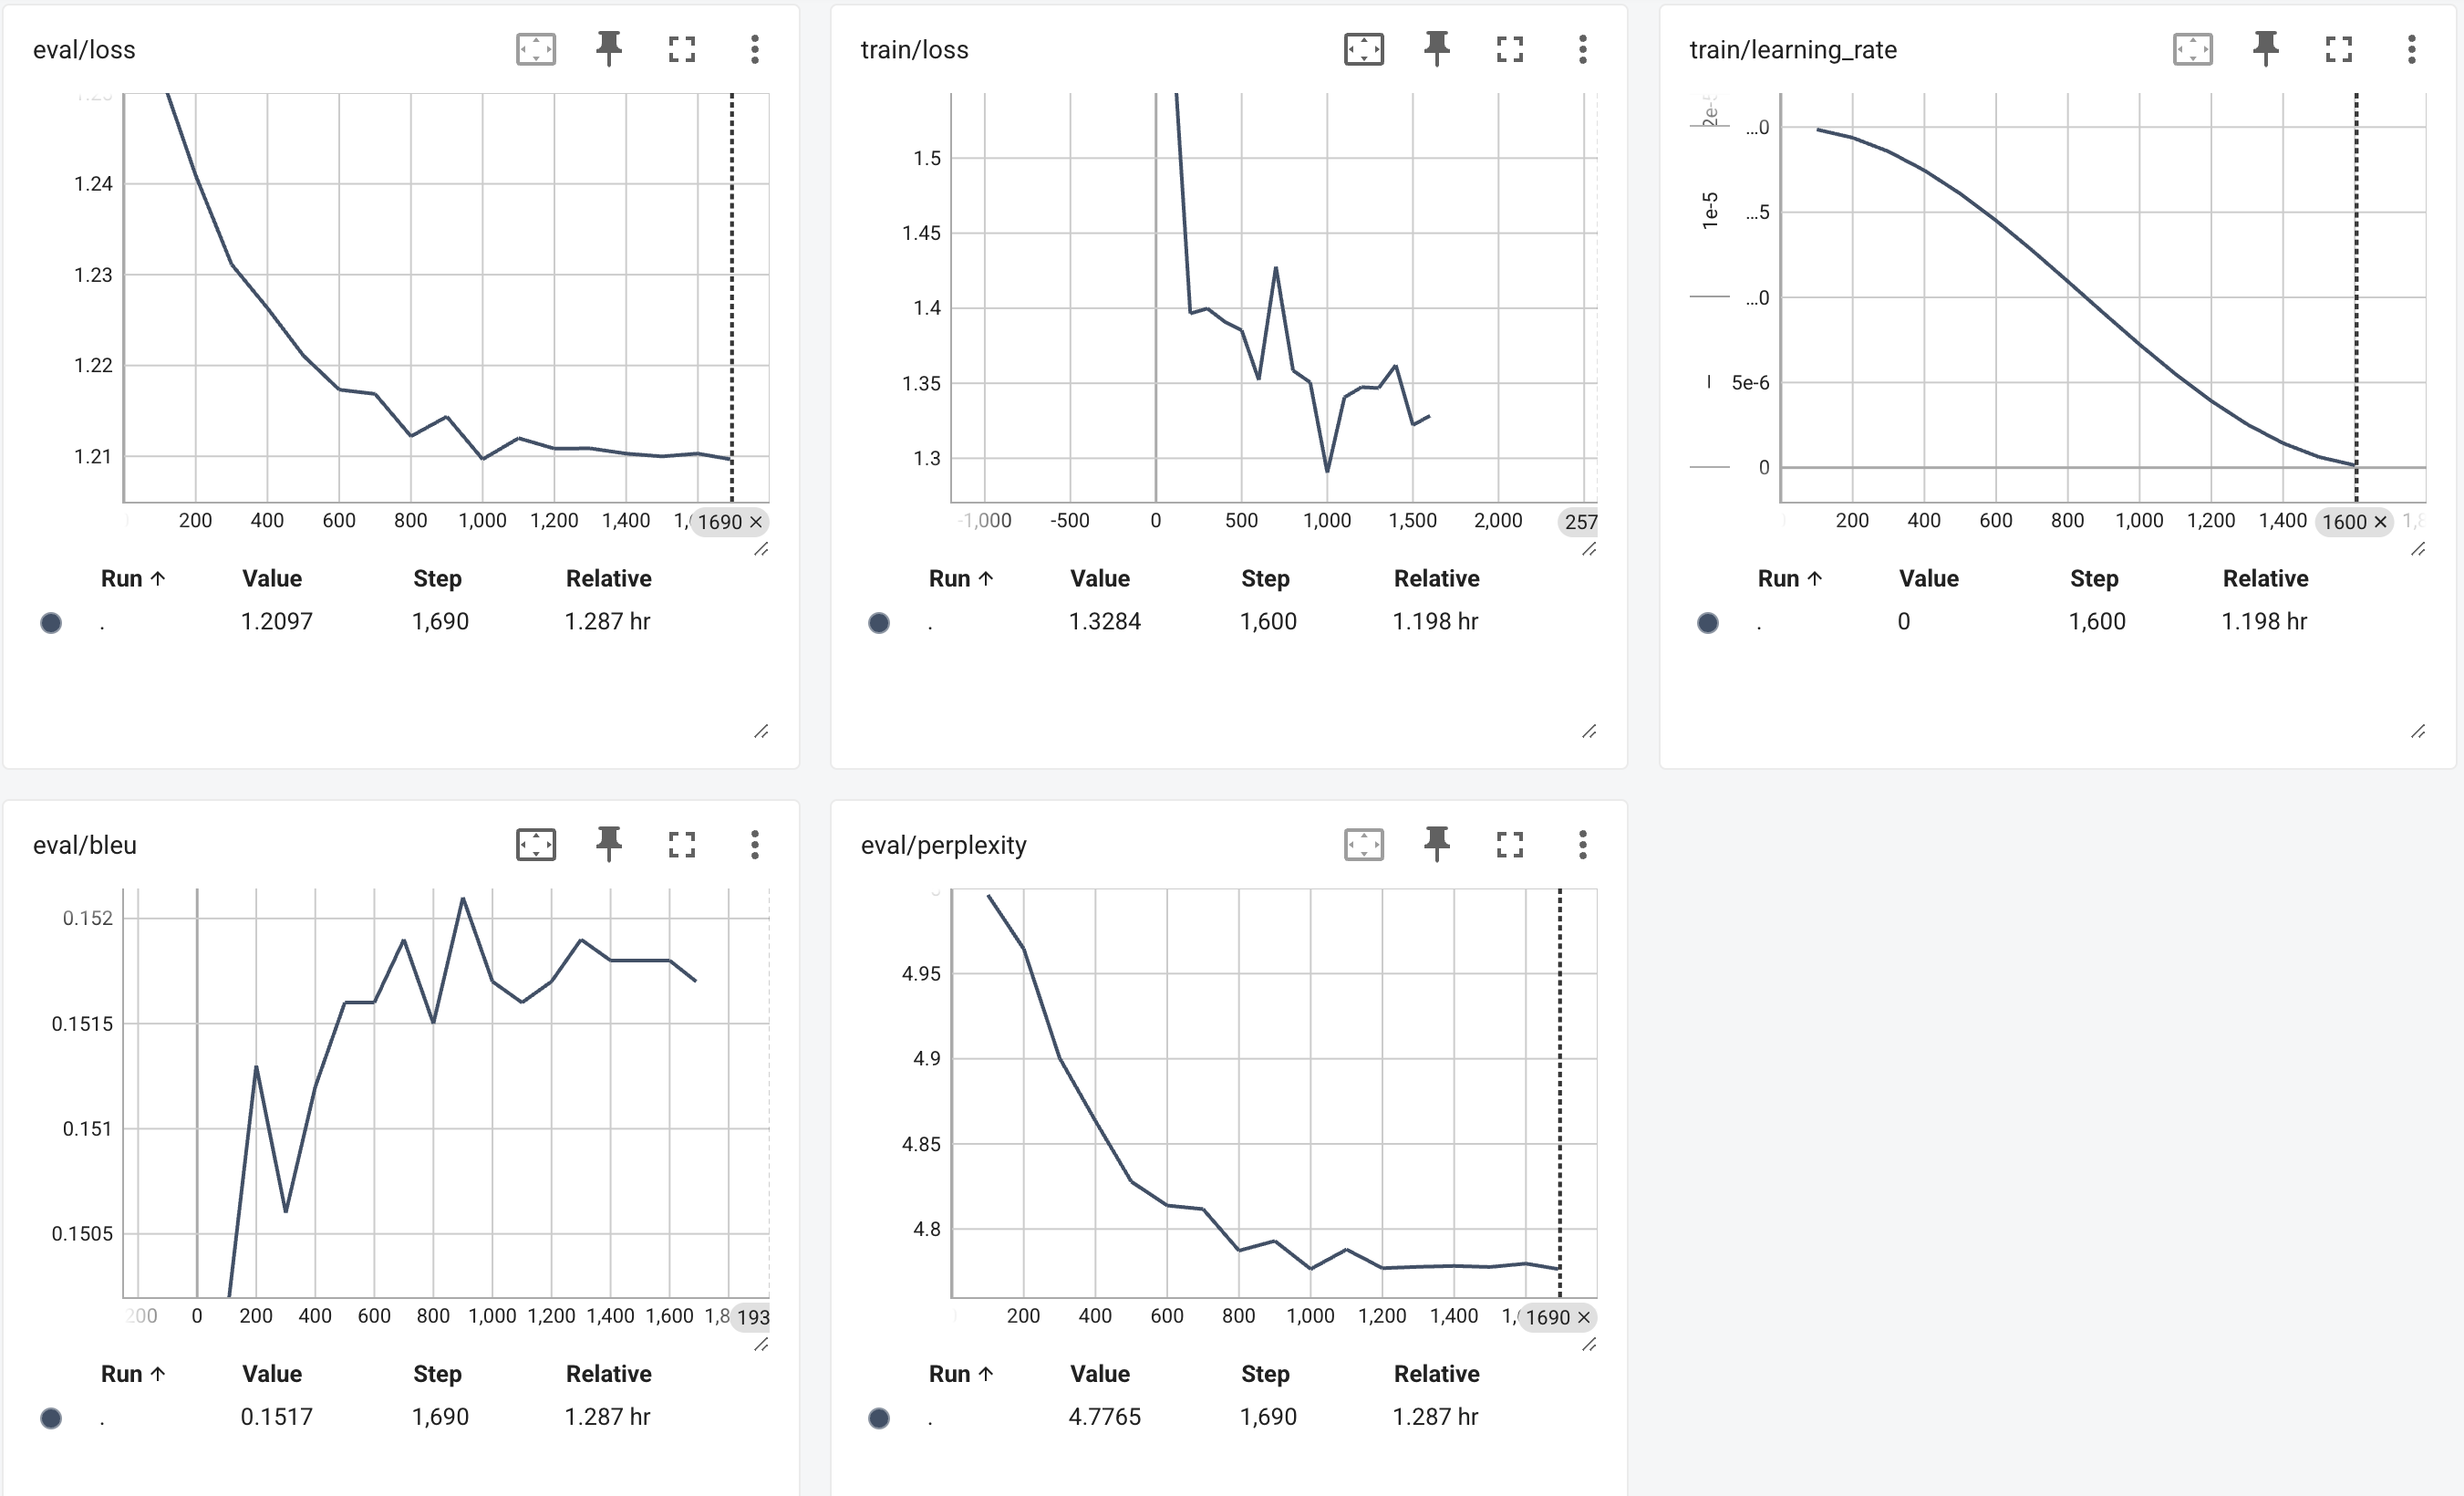


## Evaluate the finetuned model with lm-eval-harness

In [ ]:
# Run evaluation after finetuning.

# @markdown Now we run evaluation with the newly finetuned model on the same
# @markdown CoQA task to compare with the baseline results.

if train_job.end_time is None:
    print("Waiting for the training job to finish...")
    train_job.wait()
    print("The training job has finished.")

# Baseline evaluation parameters.
eval_accelerator_type = "NVIDIA_L4"  # @param ["NVIDIA_L4", "NVIDIA_H100_80GB"]

if eval_accelerator_type == "NVIDIA_L4":
    eval_machine_type = "g2-standard-96"
    eval_accelerator_count = 8
elif eval_accelerator_type == "NVIDIA_H100_80GB":
    eval_machine_type = "a3-highgpu-4g"
    eval_accelerator_count = 4
else:
    raise ValueError(f"Recommended GPU setting not found for: {eval_accelerator_type}.")

common_util.check_quota(
    project_id=PROJECT_ID,
    region=REGION,
    accelerator_type=eval_accelerator_type,
    accelerator_count=eval_accelerator_count,
    is_for_training=False,
)

gpu_memory_utilization = 0.95
max_model_len = 8192  # Maximum context length.
lora_output_dir = os.path.join(lora_output_dir, "node-0")

eval_output_dir = run_lm_evaluation_harness(
    job_name=common_util.get_job_name_with_datetime(prefix="llama3_1-vllm-eval"),
    base_model_id=pretrained_model_id,
    machine_type=eval_machine_type,
    accelerator_type=eval_accelerator_type,
    accelerator_count=eval_accelerator_count,
    gpu_memory_utilization=gpu_memory_utilization,
    max_model_len=max_model_len,
    enable_lora=True,
    lora_path=lora_output_dir.replace(
        "gs://", "/gcs/", 1
    ),  # Use GCS Fuse to access GCS.
)


# @markdown Expected evaluation results:
# @markdown  > | alias | exact_match | exact_match_stderr | f1 | f1_stderr |
# @markdown | --- | --- | --- | --- | --- |
# @markdown | coqa | 0.3213 | 0.0197 | 0.4660 | 0.0187 |

# @markdown The F1 score improves from the baseline score of 0.1872 to 0.4660.

print_coqa_result(eval_output_dir)

##  Deploy with vLLM on GPUs

In [ ]:
# @title Deploy
# @markdown This section deploys the model on an Endpoint. It takes 15 minutes to 1 hour to finish.
# @markdown [vLLM](https://docs.vllm.ai/en/latest/index.html) is used to serve the model.

# The pre-built serving docker image for vLLM.
VLLM_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-vllm-serve:20250114_0916_RC00_maas"

serve_accelerator_type = "NVIDIA_L4"  # @param ["NVIDIA_H100_80GB", "NVIDIA_L4"]

# @markdown Find Vertex AI prediction supported accelerators and regions at https://cloud.google.com/vertex-ai/docs/predictions/configure-compute.
if serve_accelerator_type == "NVIDIA_L4":
    serve_machine_type = "g2-standard-96"
    serve_accelerator_count = 8
elif serve_accelerator_type == "NVIDIA_H100_80GB":
    serve_machine_type = "a3-highgpu-4g"
    serve_accelerator_count = 4
else:
    raise ValueError(
        f"Recommended GPU setting not found for: {serve_accelerator_type}."
    )

common_util.check_quota(
    project_id=PROJECT_ID,
    region=REGION,
    accelerator_type=serve_accelerator_type,
    accelerator_count=serve_accelerator_count,
    is_for_training=False,
)

# @markdown Set `use_dedicated_endpoint` to False if you don't want to use [dedicated endpoint](https://cloud.google.com/vertex-ai/docs/general/deployment#create-dedicated-endpoint).
use_dedicated_endpoint = True  # @param {type:"boolean"}

gpu_memory_utilization = 0.85
max_model_len = 8192  # Maximum context length.

# Ensure max_model_len does not exceed the limit.
if max_model_len > 8192:
    raise ValueError("max_model_len cannot exceed 8192")


def deploy_model_vllm(
    model_name: str,
    model_id: str,
    service_account: str,
    base_model_id: str = None,
    machine_type: str = "g2-standard-8",
    accelerator_type: str = "NVIDIA_L4",
    accelerator_count: int = 1,
    gpu_memory_utilization: float = 0.9,
    max_model_len: int = 4096,
    dtype: str = "auto",
    enable_trust_remote_code: bool = False,
    enforce_eager: bool = False,
    enable_lora: bool = False,
    enable_chunked_prefill: bool = False,
    enable_prefix_cache: bool = False,
    host_prefix_kv_cache_utilization_target: float = 0.0,
    max_loras: int = 1,
    max_cpu_loras: int = 8,
    use_dedicated_endpoint: bool = False,
    max_num_seqs: int = 256,
    model_type: str = None,
) -> Tuple[aiplatform.Model, aiplatform.Endpoint]:
    """Deploys trained models with vLLM into Vertex AI."""
    endpoint = aiplatform.Endpoint.create(
        display_name=f"{model_name}-endpoint",
        dedicated_endpoint_enabled=use_dedicated_endpoint,
    )

    if not base_model_id:
        base_model_id = model_id

    # See https://docs.vllm.ai/en/latest/models/engine_args.html for a list of possible arguments with descriptions.
    vllm_args = [
        "python",
        "-m",
        "vllm.entrypoints.api_server",
        "--host=0.0.0.0",
        "--port=8080",
        f"--model={model_id}",
        f"--tensor-parallel-size={accelerator_count}",
        "--swap-space=16",
        f"--gpu-memory-utilization={gpu_memory_utilization}",
        f"--max-model-len={max_model_len}",
        f"--dtype={dtype}",
        f"--max-loras={max_loras}",
        f"--max-cpu-loras={max_cpu_loras}",
        f"--max-num-seqs={max_num_seqs}",
        "--disable-log-stats",
    ]

    if enable_trust_remote_code:
        vllm_args.append("--trust-remote-code")

    if enforce_eager:
        vllm_args.append("--enforce-eager")

    if enable_lora:
        vllm_args.append("--enable-lora")

    if enable_chunked_prefill:
        vllm_args.append("--enable-chunked-prefill")

    if enable_prefix_cache:
        vllm_args.append("--enable-prefix-caching")

    if 0 < host_prefix_kv_cache_utilization_target < 1:
        vllm_args.append(
            f"--host-prefix-kv-cache-utilization-target={host_prefix_kv_cache_utilization_target}"
        )

    if model_type:
        vllm_args.append(f"--model-type={model_type}")

    env_vars = {
        "MODEL_ID": base_model_id,
        "DEPLOY_SOURCE": "notebook",
    }

    # HF_TOKEN is not a compulsory field and may not be defined.
    try:
        if HF_TOKEN:
            env_vars["HF_TOKEN"] = HF_TOKEN
    except NameError:
        pass

    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=VLLM_DOCKER_URI,
        serving_container_args=vllm_args,
        serving_container_ports=[8080],
        serving_container_predict_route="/generate",
        serving_container_health_route="/ping",
        serving_container_environment_variables=env_vars,
        serving_container_shared_memory_size_mb=(16 * 1024),  # 16 GB
        serving_container_deployment_timeout=7200,
        model_garden_source_model_name="publishers/meta/models/llama3_1",
    )
    print(
        f"Deploying {model_name} on {machine_type} with {accelerator_count} {accelerator_type} GPU(s)."
    )
    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=service_account,
        system_labels={
            "NOTEBOOK_NAME": "model_garden_finetuning_tutorial.ipynb",
        },
    )
    print("endpoint_name:", endpoint.name)

    return model, endpoint


def predict_vllm(
    prompt: str,
    max_tokens: int,
    temperature: float,
    top_p: float,
    top_k: int,
    raw_response: bool,
    lora_weight: str = "",
    use_dedicated_endpoint: bool = False,
):
    # Parameters for inference.
    instance = {
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
        "raw_response": raw_response,
    }
    if lora_weight:
        instance["dynamic-lora"] = lora_weight
    instances = [instance]
    response = endpoints["vllm_gpu"].predict(
        instances=instances, use_dedicated_endpoint=use_dedicated_endpoint
    )

    for prediction in response.predictions:
        print(prediction)


deploy_pretrained_model_id = pretrained_model_id
print("Deploying model in:", deploy_pretrained_model_id)

models["vllm_gpu"], endpoints["vllm_gpu"] = deploy_model_vllm(
    model_name=common_util.get_job_name_with_datetime(prefix="llama3_1-vllm-serve"),
    model_id=deploy_pretrained_model_id,
    service_account=SERVICE_ACCOUNT,
    machine_type=serve_machine_type,
    accelerator_type=serve_accelerator_type,
    accelerator_count=serve_accelerator_count,
    gpu_memory_utilization=gpu_memory_utilization,
    max_model_len=max_model_len,
    enable_lora=True,
    use_dedicated_endpoint=use_dedicated_endpoint,
    enable_prefix_cache=True,
    host_prefix_kv_cache_utilization_target=0.7,
)

# @markdown Click "Show Code" to see more details.

In [ ]:
# @title Predict

# @markdown Once deployment succeeds, you can send requests to the endpoint with text prompts. Sampling parameters supported by vLLM can be found [here](https://docs.vllm.ai/en/latest/dev/sampling_params.html).

# @markdown The following example demonstrates a reading comprehension question
# @markdown answering task. The model is given a question and a short context
# @markdown passage, and must give an answer from the provided text.


# @markdown - Human: `What was Anya looking for? Context: Anya clutched the worn teddy bear, its button eye dangling precariously. She'd lost it in the park yesterday, and the thought of never seeing Mr. Snuggles again made her tummy ache. She retraced her steps, her eyes scanning the colorful playground equipment and the sprawling green lawn.`

# @markdown - Assistant: `Anya was looking for her teddy bear, Mr. Snuggles.`

# @markdown Additionally, you can moderate the generated text with Vertex AI. See [Moderate text documentation](https://cloud.google.com/natural-language/docs/moderating-text) for more details.

prompt = "What was Anya looking for? Context: Anya clutched the worn teddy bear, its button eye dangling precariously. She'd lost it in the park yesterday, and the thought of never seeing Mr. Snuggles again made her tummy ache. She retraced her steps, her eyes scanning the colorful playground equipment and the sprawling green lawn."  # @param {type: "string"}
prompt_with_headers = (
    f"<|start_header_id|>user<|end_header_id|>\\n\\n{prompt}<|eot_id|>"
    "<|start_header_id|>assistant<|end_header_id|>\n\n"
)

# @markdown If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`, you can reduce the maximum number of output tokens, such as set `max_tokens` as 20.
max_tokens = 100  # @param {type:"integer"}
temperature = 1.0  # @param {type:"number"}
top_p = 1.0  # @param {type:"number"}
top_k = 1  # @param {type:"integer"}
raw_response = False  # @param {type:"boolean"}


predict_vllm(
    prompt=prompt_with_headers,
    max_tokens=max_tokens,
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    raw_response=raw_response,
    lora_weight=lora_output_dir,
    use_dedicated_endpoint=use_dedicated_endpoint,
)

# @markdown Click "Show Code" to see more details.

Prompt:
<|start_header_id|>user<|end_header_id|>\n\nWhat was Anya looking for? Context: Anya clutched the worn teddy bear, its button eye dangling precariously. She'd lost it in the park yesterday, and the thought of never seeing Mr. Snuggles again made her tummy ache. She retraced her steps, her eyes scanning the colorful playground equipment and the sprawling green lawn.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
Output:
Anya was looking for her teddy bear, Mr. Snuggles.


## Clean up resources

In [ ]:
# @title Delete the model and endpoint

train_job.delete()

# @markdown  Delete the experiment models and endpoints to recycle the resources
# @markdown  and avoid unnecessary continuous charges that may incur.

# Undeploy model and delete endpoint.
for endpoint in endpoints.values():
    endpoint.delete(force=True)

# Delete models.
for model in models.values():
    model.delete()

delete_bucket = False  # @param {type:"boolean"}
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_NAME